In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [3]:
# Compute the Mott-Massey results
mm = LocalSystem(1.5)
mm_vtilde = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)
mm_evals, mm_evecs = bind.bound_states(mm_vtilde, 0, 0, mm.q, mm.wq)

In [4]:
def ftr(state, r, q, wq):
    y = np.array([np.sum(np.sqrt(2/np.pi) * wq * q**2 * state * spherical_jn(0, q*ri)) for ri in r])
    return 1/np.sqrt(np.sum(ls.r_weights * ls.r_nodes**2 * y**2)) * y


def local_LO_counterterm(r, R):
    return np.exp(-(r/R)**4)


def psi0(ls, g, ii, full=False):
    evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)
    psi0 = np.zeros(7)
    for i in range(7):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) / ls.r_nodes
        if full:
            psi0[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_NLO_counterterm(ls.r_nodes, Ri) * psi**2)
        else:
            psi0[i] = psi[ii]**2
    return psi0


def psi_Vnlo_psi(evals, evecs, R):
    overlap = np.zeros(7)
    for i in range(7):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) / ls.r_nodes
        overlap[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_LO_counterterm(ls.r_nodes, R) * psi**2)
    return overlap


def f_min(c2, evals, evecs, R):
    overlap = psi_Vnlo_psi(evals, evecs, R)
#     return np.linalg.norm(mm_evals[-2:] - (evals[-2:] + c2*overlap[-2:]))
    return (mm_evals[5] - evals[5]*(1 + c2*overlap[5])) / mm_evals[5]

In [5]:
Rs, gs = np.loadtxt('rgflow_local_lo_B6_fix.txt', unpack=True)

In [6]:
Ri = Rs[0]
gi = gs[0]
ls = LocalSystem(Ri, nq=250)
evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(gi, 0), 1, ls.q, ls.wq)

In [7]:
guess = 0.61
f_min(guess, evals, evecs, Ri)

-0.0007206366035746872

In [8]:
class Spectrum:
    def __init__(self, evals, evecs, R, g_nlo):
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = R
        self.g_nlo = g_nlo
        
        self.overlap = psi_Vnlo_psi(self.lo_evals, self.lo_evecs, self.R)
        self.nlo_evals = self.lo_evals + self.g_nlo*self.lo_evals*self.overlap
        self.nlo_evals[-1] = self.lo_evals[-1]

In [9]:
gnlos = np.zeros(Rs.size)
specs = []
for (i, (Ri, gi)) in enumerate(zip(Rs, gs)):
    ls = LocalSystem(Ri, nq=250)
    evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(gi, 0), 1, ls.q, ls.wq)
    result = optimize.fsolve(f_min, guess, args=(evals, evecs, Ri), xtol=1e-10)
    gnlo = result[0]
    
    gnlos[i] = gnlo
    specs.append(Spectrum(evals, evecs, Ri, gnlo))
    
    print(f'i = {i}  R = {Ri:.4e}  g_nlo = {gnlo:.4e}')
    if i == Rs.size-1:
        break
    
    if i < 5:
        guess = gnlo
    else:
        curve = interp1d(Rs[i-5:i], gnlos[i-5:i], kind='cubic', fill_value='extrapolate')
        try:
            guess = curve(Rs[i+1])
        except:
            print('Did not get a good guess.')
            break
    
    

i = 0  R = 3.2710e+00  g_nlo = 6.0597e-01
i = 1  R = 3.0823e+00  g_nlo = 4.6387e-01


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


i = 2  R = 2.9142e+00  g_nlo = 2.5461e-01
i = 3  R = 2.7634e+00  g_nlo = 9.3937e-02
i = 4  R = 2.6275e+00  g_nlo = 3.3217e-02
i = 5  R = 2.5044e+00  g_nlo = 3.3369e-02
i = 6  R = 2.3922e+00  g_nlo = 3.5374e-02
i = 7  R = 2.2897e+00  g_nlo = 1.4663e-02
i = 8  R = 2.1956e+00  g_nlo = -2.2161e-02
i = 9  R = 2.1089e+00  g_nlo = -5.6887e-02
i = 10  R = 2.0288e+00  g_nlo = -8.0042e-02
i = 11  R = 1.9546e+00  g_nlo = -9.3375e-02
i = 12  R = 1.8856e+00  g_nlo = -1.0428e-01
i = 13  R = 1.8213e+00  g_nlo = -1.1453e-01
i = 14  R = 1.7613e+00  g_nlo = -1.2388e-01
i = 15  R = 1.7051e+00  g_nlo = -1.3001e-01
i = 16  R = 1.6524e+00  g_nlo = -1.3022e-01
i = 17  R = 1.6028e+00  g_nlo = -1.2306e-01
i = 18  R = 1.5561e+00  g_nlo = -1.1399e-01
i = 19  R = 1.5121e+00  g_nlo = -1.1777e-01
i = 20  R = 1.4704e+00  g_nlo = -1.7614e-01
i = 21  R = 1.4311e+00  g_nlo = -3.6725e-01
i = 22  R = 1.3937e+00  g_nlo = -8.6162e-01
i = 23  R = 1.3583e+00  g_nlo = -1.9662e+00
i = 24  R = 1.3246e+00  g_nlo = -4.0660e+00
i 

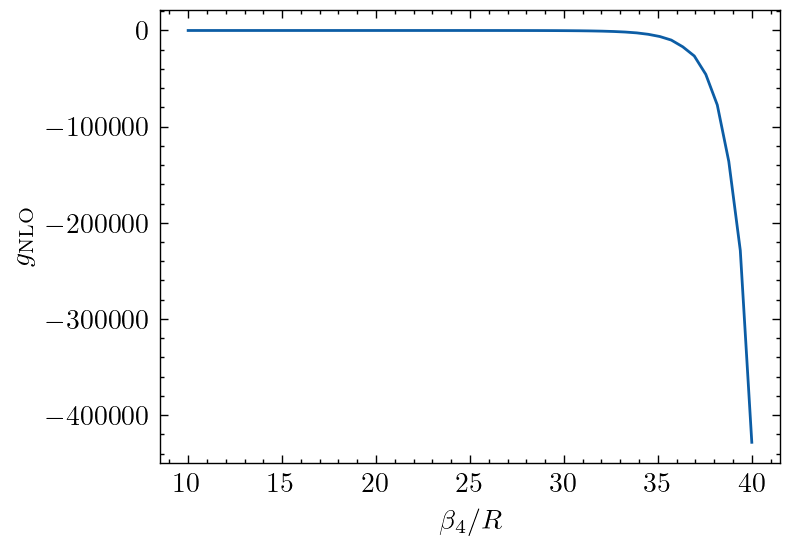

In [10]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(const.BETA4/Rs, gnlos)

# ax.set_ylim([-1, 1])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$g_{\rm NLO}$');

In [11]:
np.savetxt('rgflow_local_nlo_B5_fix.txt', np.vstack((Rs, gnlos)).T, header='R  g_NLO')

In [12]:
lo_specs = np.array([spec.lo_evals for spec in specs])
nlo_specs = np.array([spec.nlo_evals  for spec in specs])

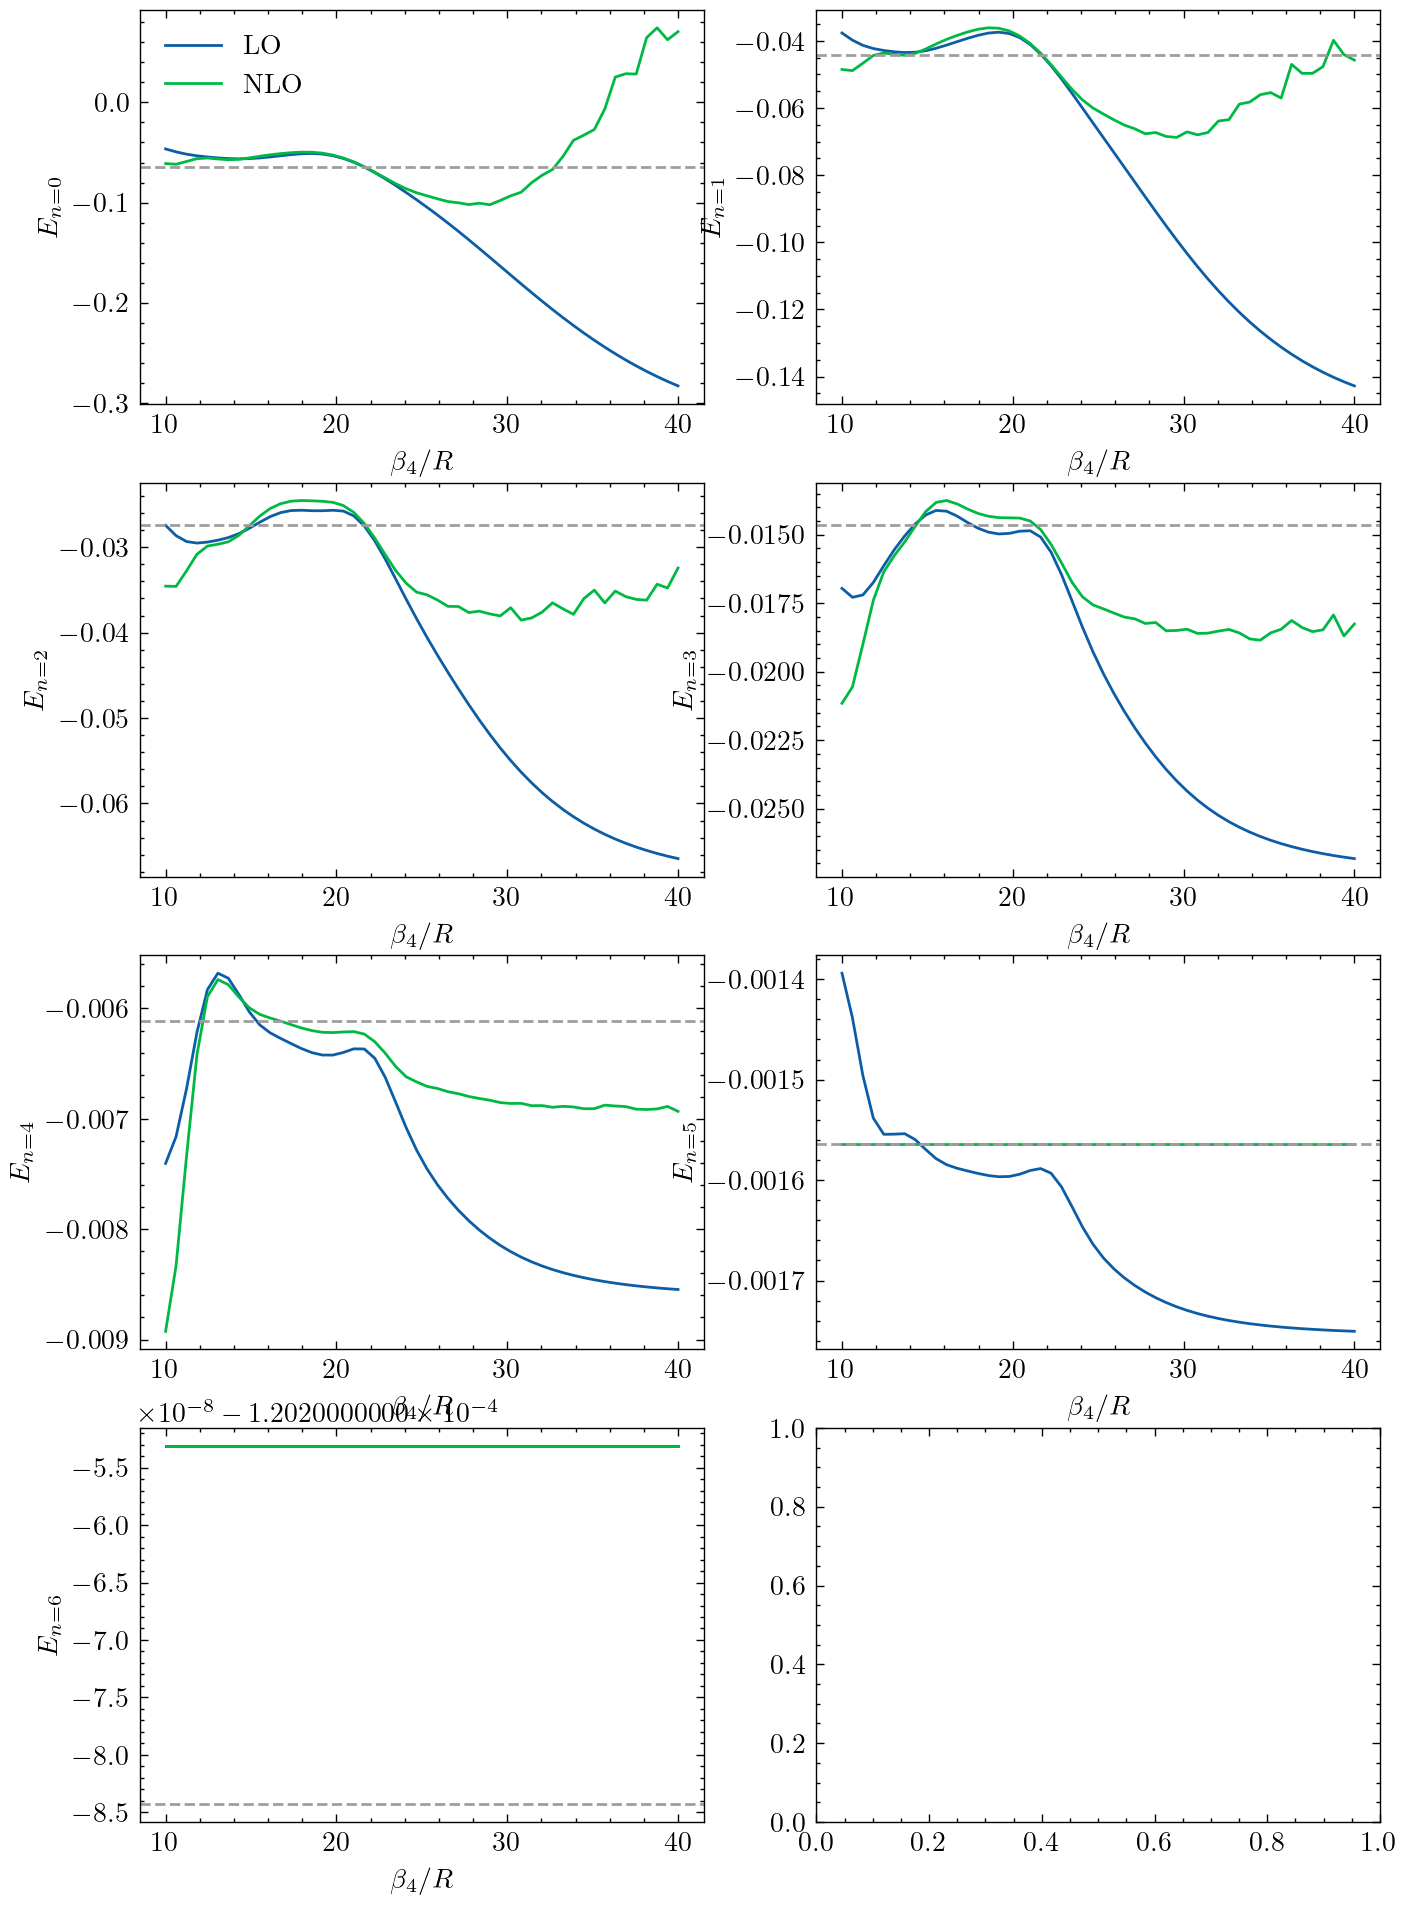

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, lo_specs[:, i], label=r'LO')
    ax[i//2, i%2].plot(const.BETA4/Rs, nlo_specs[:, i], label=r'NLO')
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i))
    if i == 0:
        ax[0, 0].legend()

In [14]:
all_overlaps = np.array([spec.overlap for spec in specs])

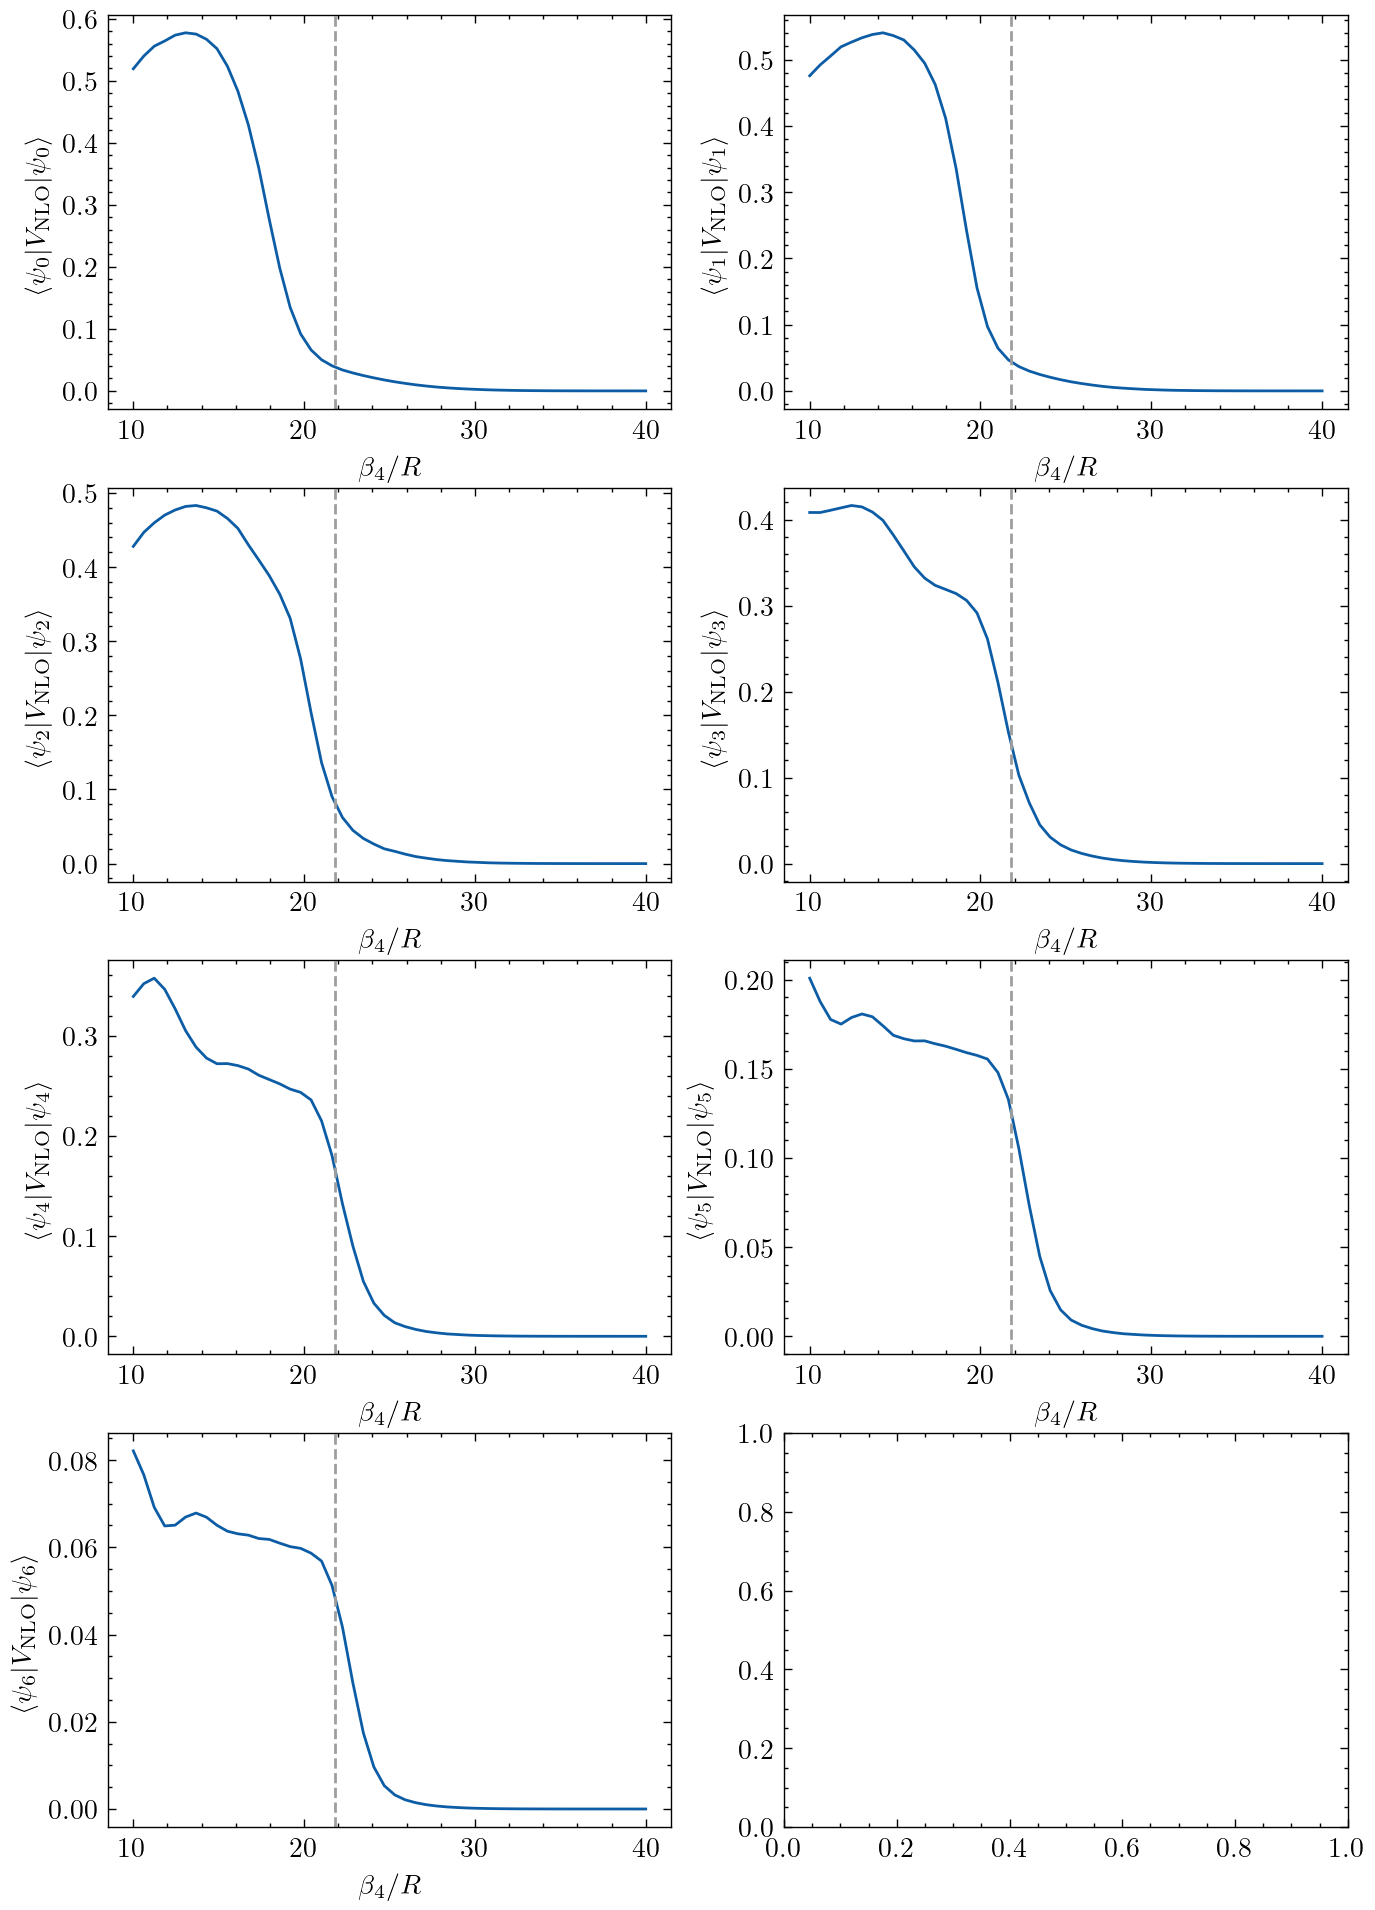

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, all_overlaps[:, i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$\langle\psi_{%d}|V_{\rm NLO}|\psi_{%d}\rangle$' % (i, i))
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

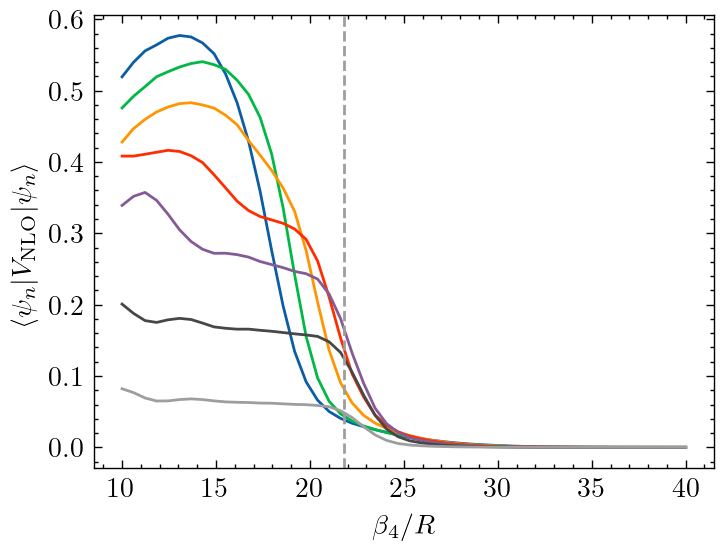

In [16]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs, all_overlaps[:, i])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$\langle\psi_{n}|V_{\rm NLO}|\psi_{n}\rangle$')
ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')

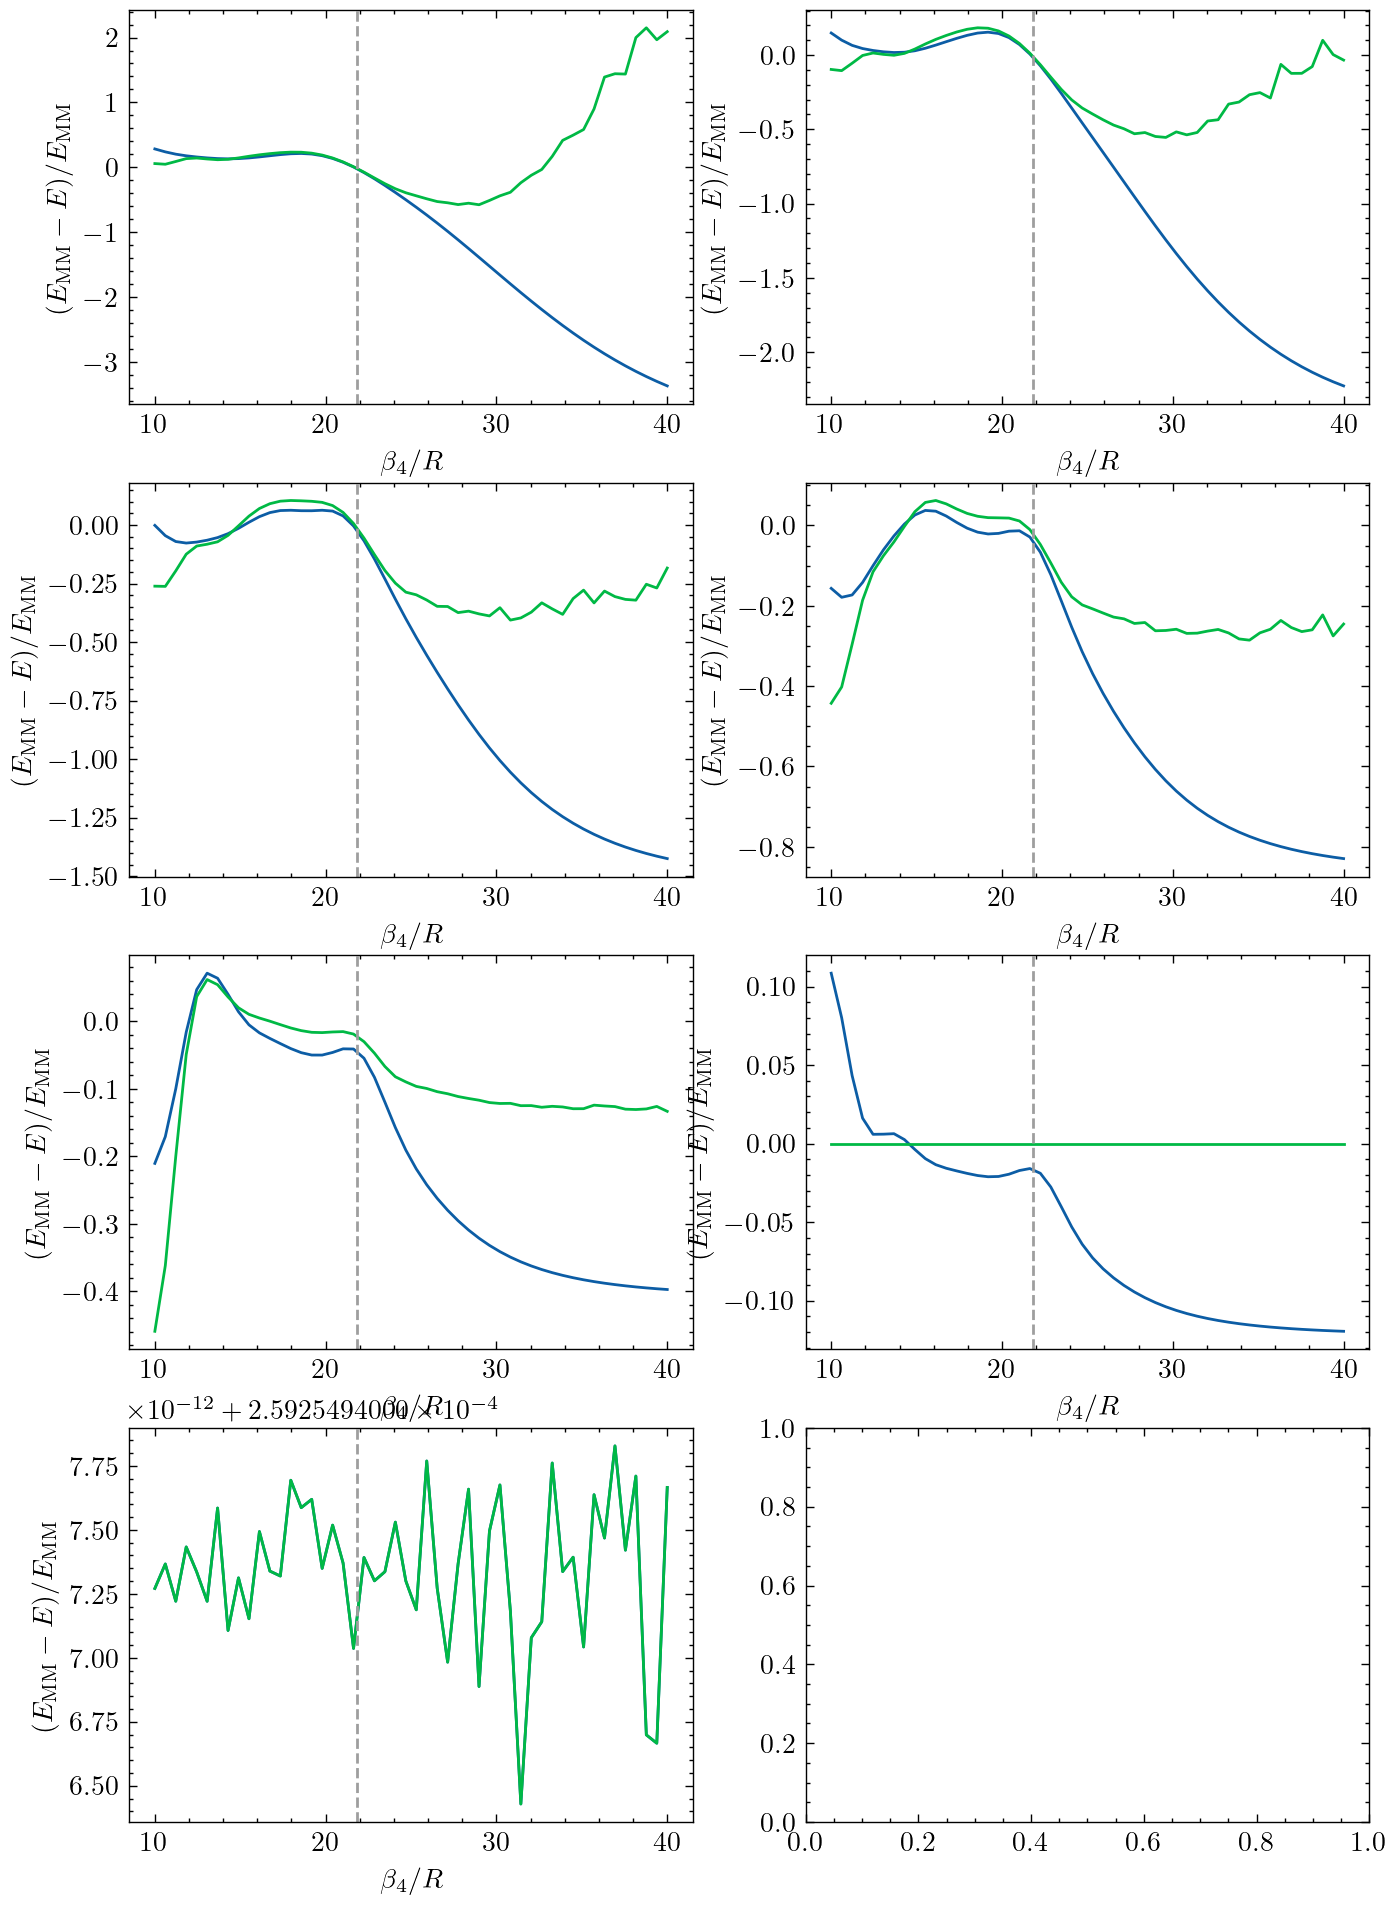

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - lo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - nlo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

In [22]:
nlo_specs.T

array([[-0.06105801, -0.06173612, -0.05898007, -0.05611724, -0.05551005,
        -0.05647273, -0.05721126, -0.05680236, -0.05542109, -0.05377078,
        -0.05230714, -0.05111686, -0.05016909, -0.04963944, -0.04972229,
        -0.05065296, -0.05255671, -0.05548282, -0.05939693, -0.0641833 ,
        -0.06963122, -0.0754321 , -0.08114526, -0.08619958, -0.09019794,
        -0.09324373, -0.09621958, -0.09896436, -0.10020458, -0.10199071,
        -0.10062044, -0.10215408, -0.09787718, -0.09326457, -0.08969601,
        -0.0801715 , -0.07273388, -0.06694405, -0.05388724, -0.03787932,
        -0.03267125, -0.02705884, -0.0065219 ,  0.02530362,  0.02863076,
         0.02829551,  0.06470129,  0.07448832,  0.06256132,  0.07063174],
       [-0.04851277, -0.04887124, -0.04666011, -0.04435247, -0.04361455,
        -0.04402966, -0.04429556, -0.04372961, -0.04243935, -0.04093059,
        -0.03956244, -0.03839071, -0.0373608 , -0.03654901, -0.0361102 ,
        -0.03623803, -0.03704585, -0.03856094, -0.

In [19]:
np.savetxt('spectra_local_nlo_B5_fix.txt', np.vstack((Rs, nlo_specs.T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6')

In [20]:
np.savetxt('spectra_Mott_Massey.txt', mm_evals)